In [1]:
# Reference paper:
# Duarte 2018, Gradient-Based Structural Estimation (working paper)

In [2]:
# Import libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import tensorflow_probability as tfp
%matplotlib inline

In [3]:
# Terminal date
T = 9

# Network design and optization hyperparameters
batch_size = 5000
activation = tf.nn.relu

optimizer = tf.keras.optimizers.Adam()
optimizer_moment_network = tf.keras.optimizers.Adam()

state_size = 3


# function that creates a network
def net():
    model = Sequential([Dense(32, activation, input_shape=(state_size,)),
                        Dense(32, activation),
                        Dense(1, 'sigmoid')])
    return model


n = [net() for _ in range(T)]
Θ = [n[t].weights for t in range(T)]
Θ = [item for sublist in Θ for item in sublist]

# moment network
g = Sequential([Dense(32, 'elu', input_shape=(1,)),
                Dense(32, 'elu'),
                Dense(1)])


In [4]:
# %% Economic Model ------------------------------------------------------

# Model parameters
σ_ε = 0.02058
λ_ε = 0.99
β = .97

# Prices
r = 0.07
w = 5

μx = 2.
σx = 1.

μe = 0.
σe = .14

μγ = 3.
σγ = 1.

def u(C, γ):
    return C**(1 - γ) / (1 - γ)


def normalize(x, e, γ):
    x = (x - μx) / σx
    e = (e - μe) / σe
    γ = (γ - μγ) / σγ

    X = tf.concat([x, e, γ], 1)
    return X


def simulate():
    x0 = tf.random.uniform([batch_size, 1], minval=.01, maxval=4)
    e0 = tf.random.uniform([batch_size, 1], minval=-.25, maxval=.25)
    γ = tf.random.uniform([batch_size, 1], minval=1.2, maxval=5)

    # Normal shock at t=0
    def ε():
        return tf.random.normal(shape=[batch_size, 1])

    # Organize variables and shocks in dictionaries
    x = {0: x0}
    e = {0: e0}
    s = {}
    y = {}
    C = {}

    for t in range(T):
        # The inputs of the network are wealth and productivity at t
        X = normalize(x[t], e[t], γ)
        s[t] = n[t](X)

        # Disposable income
        y[t] = (1 + r) * x[t] + tf.exp(e[t]) * w

        # Consumption
        C[t] = (1 - s[t]) * y[t]

        # Next states
        e[t + 1] = λ_ε * e[t] + σ_ε * ε()
        x[t + 1] = s[t] * y[t]

    # Terminal values
    C[T] = (1 + r) * x[T] + tf.exp(e[T]) * w

    # Moment
    moment = C[T]

    V = sum([β**t * u(C[t], γ) for t in range(T + 1)])
    return V, [x, e, γ], moment


@tf.function
def training_step():
    with tf.GradientTape(persistent=True) as tape:
        V, [x, e, γ], moment = simulate()
        objective = -tf.reduce_mean(V)

        predicted = g(γ - μγ)
        loss = tf.reduce_mean((predicted - moment)**2)

    # optimization    EV, results = training_step()
    grads = tape.gradient(objective, Θ)
    optimizer.apply_gradients(zip(grads, Θ))

    # Construct the moment network
    ΘM = g.weights
    grads = tape.gradient(loss, ΘM)
    optimizer_moment_network.apply_gradients(zip(grads, ΘM))
    return -objective, [x, e, γ]



In [5]:
def loss_function(γ):
    target = 5.87
    with tf.GradientTape() as tape:
        tape.watch(γ)
        L = (g(γ - μγ) - target)**2
        dL = tape.gradient(L, γ)
    return L[0, 0], dL


start = tf.constant([3.])


def estimate(start):
    optim_results = tfp.optimizer.bfgs_minimize(
        loss_function, initial_position=start, max_iterations=5)
    β0 = optim_results.position
    return β0.numpy()[0]


In [6]:
γ_buffer = []

n_iterations = 10000
for iteration in range(n_iterations):
    EV, results = training_step()
    if iteration % 1000 == 0:
        print(str((iteration) / n_iterations * 100) + '%')

    if iteration % 50 == 0:
        start = tf.random.uniform([1], 1.2, 5.)
        γ_star = estimate(start)
        γ_buffer.append(γ_star)

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%


In [7]:
def plot(results, color='blue'):

    def plot_one(t, color):
        xt = results[0][t]
        et = tf.zeros_like(xt)
        γ = 2. * tf.ones_like(xt)

        X = normalize(xt, et, γ)
        s = n[t](X)

        # Disposable income
        y = (1 + r) * xt + tf.exp(et) * w

        # Consumption
        C = (1 - s) * y

        plt.scatter(xt, C, s=1, color=color)

    plt.subplot(1, 2, 1)
    plot_one(t=0, color='b')
    plot_one(t=3, color='r')
    plot_one(t=6, color='k')

    plt.plot(xgrid, C[0, :, 10])
    plt.plot(xgrid, C[3, :, 10])
    plt.plot(xgrid, C[6, :, 10])

    plt.subplot(1, 2, 2)
    γ = tf.reshape(tf.linspace(1.2, 5., 1000), [-1, 1])
    m_hat = moment_network(γ - μγ)

    γ_ = [1.2, 1.5, 2, 2.5, 3, 3.5, 4.5]
    m_ = [6.22, 6.05, 5.87, 5.77, 5.70, 5.65, 5.59]
    plt.plot(γ, m_hat, color=color)
    plt.scatter(γ_, m_, color='r')
    plt.show()
    plt.pause(1e-6)

    plt.show()
    plt.pause(1e-9)

(2.0626829, 0.38352233)

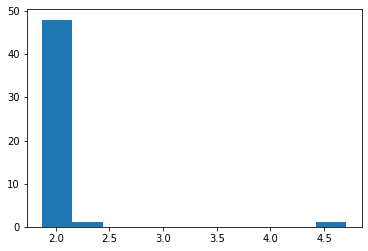

In [8]:
γ_ = np.array(γ_buffer[-50:])
γ_ = γ_[γ_ < 5]
γ_ = γ_[γ_ > 1]
plt.hist(γ_)

γ_.mean(), γ_.std()


In [9]:
def sample_γ(shape):
    out = tf.random.normal(shape, γ_.mean(), γ_.std())
    out = tf.maximum(out, 1.2)
    out = tf.minimum(out, 5)
    return out


# If you want to reduce the standard deviations, you can
# reduce the learning rates
optimizer.lr.assign(1e-5)
optimizer_moment_network.lr.assign(1e-5)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=1e-05>

In [10]:
def simulate():
    x0 = tf.random.uniform([batch_size, 1], minval=.01, maxval=4)
    e0 = tf.random.uniform([batch_size, 1], minval=-.25, maxval=.25)
    γ = sample_γ([batch_size, 1])

    # Normal shock at t=0
    def ε():
        return tf.random.normal(shape=[batch_size, 1])

    # Organize variables and shocks in dictionaries
    x = {0: x0}
    e = {0: e0}
    s = {}
    y = {}
    C = {}

    for t in range(T):
        # The inputs of the network are wealth and productivity at t
        X = normalize(x[t], e[t], γ)
        s[t] = n[t](X)

        # Disposable income
        y[t] = (1 + r) * x[t] + tf.exp(e[t]) * w

        # Consumption
        C[t] = (1 - s[t]) * y[t]

        # Next states
        e[t + 1] = λ_ε * e[t] + σ_ε * ε()
        x[t + 1] = s[t] * y[t]

    # Terminal values
    C[T] = (1 + r) * x[T] + tf.exp(e[T]) * w

    # Moment
    moment = C[T]

    V = sum([β**t * u(C[t], γ) for t in range(T + 1)])
    return V, [x, e, γ], moment


@tf.function
def training_step():
    with tf.GradientTape(persistent=True) as tape:
        V, [x, e, γ], moment = simulate()
        objective = -tf.reduce_mean(V)

        predicted = g(γ - μγ)
        loss = tf.reduce_mean((predicted - moment)**2)

    # optimization
    grads = tape.gradient(objective, Θ)
    optimizer.apply_gradients(zip(grads, Θ))

    # Construct the moment network
    ΘM = g.weights
    grads = tape.gradient(loss, ΘM)
    optimizer_moment_network.apply_gradients(zip(grads, ΘM))
    return -objective, [x, e, γ]



In [11]:
γ_buffer = []
n_iterations = 10000
for iteration in range(n_iterations):
    EV, results = training_step()
    if iteration % 1000 == 0:
        print(str((iteration) / n_iterations * 100) + '%')

    if iteration % 50 == 0:
        start = sample_γ(shape=[1])
        γ_star = estimate(start)
        γ_buffer.append(γ_star)


0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%


2.000488 0.0074544717


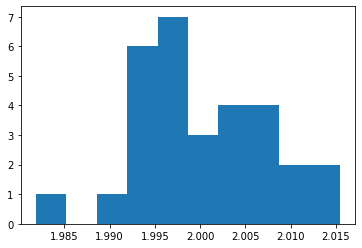

In [12]:
γ_ = np.array(γ_buffer[-30:])
γ_ = γ_[γ_ < 5]
γ_ = γ_[γ_ > 1]
plt.hist(γ_)

print(γ_.mean(), γ_.std())


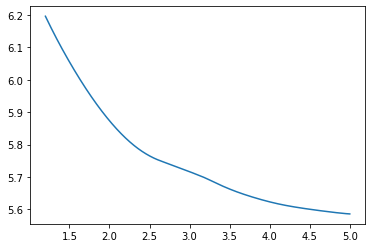

In [14]:
γ = tf.reshape(tf.linspace(1.2, 5., 1000), [-1, 1])
m_hat = g(γ - μγ)
plt.plot(γ, m_hat)
